### Patrick Horlaville (260931235) - Problem Set 4 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin, Daniel Coelho

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import astropy.units as un

## Problem 1

a)

We first load the data

In [2]:
data = np.load('sidebands.npz')
t = data['time']
d = data['signal']

(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04,  4.5e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

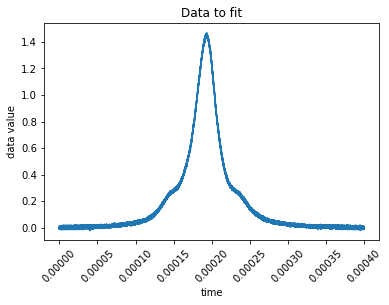

In [3]:
plt.plot(t, d)
plt.xlabel('time')
plt.ylabel('data value')
plt.title('Data to fit')
plt.xticks(rotation = 45)

Now we would like to model the data as a single Lorentzian and use analytic derivatives. To do so, we use Newton's method to carry out the fit. We parametrize the Lorentzian as $d = \frac{a}{1 + (t - t_0)^2/\omega^2}$

From the data, we can come up with initial guesses for the different parameters we will use: amplitude $a$ ~ 1.4, peak location $t_0$ ~ 0.00019 and peak spread $\omega$ ~ 0.00001

In [4]:
p0 = np.array([1.4, 0.00019, 0.00001])

Use code snippet from "newton.py" from the modelling directory, adapting it to the form of the model we are using for $d$:

In [5]:
def lorentz_d(p, t):
    
    a, t0, w = p[0], p[1], p[2]
    y = a/(1 + ((t - t0)/w)**2)
    grad = np.zeros([t.size, p.size])

    grad[:,0] = 1.0/(p[1] + (t - p[2])**2)
    grad[:,1] = - p[0]/(p[1] + (t - p[2])**2)**2
    grad[:,2] = p[0]*2*(t - p[2])/(p[1] + (t - p[2])**2)**2
    
    return y, grad

In [6]:
def newtons_method_lorentz(p, t):
    
    y_true = data['signal']
    
    new_ps = p

    for i in range(100):
        pred, grad = lorentz_d(new_ps, t)  
        res = y_true - pred  
        res = np.matrix(res).T
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(new_ps)):
            new_ps[i] += dp[i]
        new_ps = np.asarray(new_ps)
        
    return new_ps

In [7]:
p_new1a = newtons_method_lorentz(p0, t)

In [8]:
y1a, grad1a = lorentz_d(p_new1a, t)

Parameters found: a = 1.3999999965497165 , t_0 = 0.0001898262518406272 , omega = -1.4119742103716972e-05


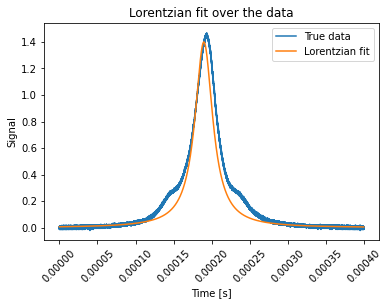

In [9]:
plt.plot(t, d, label = 'True data')
plt.plot(t, y1a, label = 'Lorentzian fit')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Lorentzian fit over the data')
plt.legend()
plt.xticks(rotation = 45)
print('Parameters found: a =', p_new1a[0], ', t_0 =', p_new1a[1], ', omega =', p_new1a[2])

b)

Now we estimate the noise in the data, and from it, estimate the error on our parameters

In [10]:
sigma = np.std(d)
sc_sigma = sigma/np.sqrt(len(d))

In [11]:
cov_inv = np.eye(len(t))
np.fill_diagonal(cov_inv, 1/(sc_sigma**2))

The following doesn't work. The simple first matrix multiplication to be done in the 'cov' definition 
kills the kernel after a minute or two. After all, those are 100 000 by 100 000 matrices, but I don't know
if this was to be expected.

In [ ]:
'''
cov = np.linalg.pinv(grad.T@cov_inv@grad)
errs = np.sqrt(np.diag(cov))
print('The error on a is:', errs[0])
print('The error on t0 is:', errs[1])
print('The error on w is:', errs[2])
'''

c)

We repeat part a) but using numerical derivatives. First we define a derivative function, then we will have different f functions whose variable will be the different parameters. The derivative is taken with respect to the different parameters to have the gradients for each parameter (to do so, we use lambda functions. It helps in having to avoid defining many different functions. We only define three f functions that take as variable each parameter. We compute the gradient numerically with a derivative function). We take an arbitrarily small time step dt.

In [12]:
dt = 10**(-8)
deriv = lambda f, t: 1/(2*dt)*(f(t + dt) - f(t - dt))

In [13]:
def lorentz_num(p, t):
    
    a, t0, w = p[0], p[1], p[2]
    y = a/(1 + ((t - t0)/w)**2)

    f_a = lambda x: x/(1 + ((t - t0)/w)**2)
    f_t0 = lambda y: a/(1+((t - y)/w)**2)
    f_w = lambda z: a/(1+((t - t0)/z)**2)

    grad = np.zeros([len(t), len(p)])
    grad[:,0] = deriv(f_a, a)
    grad[:,1] = deriv(f_t0, t0)
    grad[:,2] = deriv(f_w, w)

    return y, grad

In [14]:
def newtons_method_lorentz_num(data, p, t, n):
    
    y_true = data['signal']
    new_ps = p
    
    for i in range(n):
        calc, grad = lorentz_num(new_ps, t)  
        res = y_true - calc  
        res = np.matrix(res).T  
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(new_ps)):
            new_ps[i] += dp[i]
        new_ps = np.asarray(new_ps)
        
    return new_ps

In [15]:
p_new1b = newtons_method_lorentz_num(data, p0, t, 500)
y1b, grad1b = lorentz_d(p_new1b, t)

Parameters found: a = 1.4228106821838835 , t_0 = 0.0001923586492623034 , omega = -1.792369075490326e-05


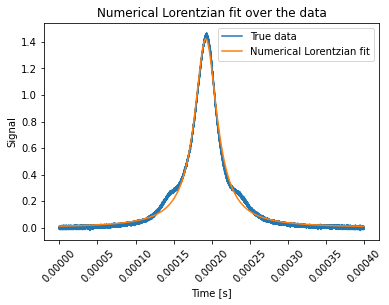

In [16]:
plt.plot(t, d, label = "True data")
plt.plot(t, y1b, label = "Numerical Lorentzian fit")
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Numerical Lorentzian fit over the data')
plt.legend()
plt.xticks(rotation = 45)
print('Parameters found: a =', p_new1b[0], ', t_0 =', p_new1b[1], ', omega =', p_new1b[2])

d)

Now we repeat part c) but we model the data as the addition of three Lorentzian functions. Very similarly, we define our lambda functions for each parameter and we define the gradient numerically with our deriv function.

In [37]:
def lorentzian_3lor(p, t):
    
    a, b, c, t0, t1, w = p
    y = a/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)

    fa = lambda x1: x1/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)
    fb = lambda x2: a/(1 + ((t - t0)/w)**2) + x2/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)
    fc = lambda x3: a/(1 + ((t - t0)/w)**2) + b/(1 +((t - t0 + t1)/w)**2) + x3/(1 + ((t - t0 - t1)/w)**2)
    ft0 = lambda x4: a/(1 + ((t - x4)/w)**2) + b/(1 +((t - x4 + t1)/w)**2) + c/(1 + ((t - x4 - t1)/w)**2)
    ft1 = lambda x5: a/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + x5)/w)**2) + c/(1 + ((t - t0 - x5)/w)**2)
    fw = lambda x6: a/(1 + ((t - t0)/x6)**2) + b/(1 + ((t - t0 + t1)/x6)**2) + c/(1 + ((t - t0 - t1)/x6)**2)

    grad = np.zeros([len(t), len(p)])
    grad[:,0], grad[:,1], grad[:,2] = deriv(fa, a), deriv(fb, b), deriv(fc, c)
    grad[:,3], grad[:,4], grad[:,5] = deriv(ft0, t0), deriv(ft1, t1), deriv(fw, w)

    return y, grad

In [40]:
def newtons_method_3lor(data, p, t, n):
    
    y_true = data['signal']
    p_new = p
    
    for i in range(n):
        calc, grad = lorentzian_3lor(p_new, t)  
        res = y_true - calc  
        res = np.matrix(res).T
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(p_new)):
            p_new[i] += dp[i]
            
        p_new = np.asarray(p_new)
        
    return p_new

We need to have estimates for the amplitude of the two other Lorentzian peaks, which from the data plot seem to be of order ~ 0.3, and their distance from the main peak seems to be of order ~ 0.00005

In [44]:
p0_3lor= np.array([1.5, 0.3, 0.3, 0.00019, 0.00005, 0.00001])
p_new1d = newtons_method_3lor(data, p0_3lor, t, 100) 
y1d, grad1d = lorentzian_3lor(p_new1d, t)
print("The best-fit parameters for the sum of Lorentzians using numerical derivatives are: ", p_new1d)

The best-fit parameters for the sum of Lorentzians using numerical derivatives are:  [1.44299239e+00 1.03910780e-01 6.47325300e-02 1.92578522e-04
 4.45671630e-05 1.60651094e-05]


Parameters found:
a = 1.4429923932697661
b = 0.10391077998946781
c = 0.06473253000825782
t0 = 0.00019257852173624665
t1 = 4.456716295451412e-05
w = 1.6065109423762263e-05


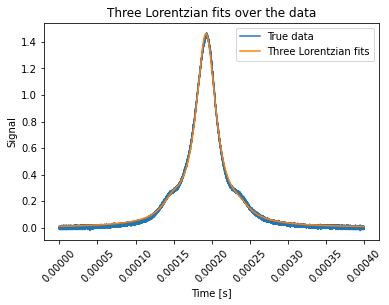

In [45]:
plt.plot(t, d, label = 'True data')
plt.plot(t, y1d, label = 'Three Lorentzian fits')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Three Lorentzian fits over the data')
plt.legend()
plt.xticks(rotation = 45)

print('Parameters found:') 
print('a =', p_new1d[0])
print('b =', p_new1d[1])
print('c =', p_new1d[2])
print('t0 =', p_new1d[3])
print('t1 =', p_new1d[4])
print('w =', p_new1d[5])

In [ ]:
# Again, this code chunk does not work
cov_inv_d = cov_inv
cov_d = np.linalg.pinv(gradd.transpose()@cov_inv_d@gradd)
errs_d = np.sqrt(np.diag(cov_d))

In [ ]:
print('Errors on parameters are:')
print('Error on a is:', errs_d[0])
print('Error on b is:', errs_d[1])
print('Error on c is:', errs_d[2])
print('Error on t0 is:', errs_d[3])
print('Error on t1 is:', errs_d[4])
print('Error on w is:', errs_d[5])

e)

Here we look at the residuals from the calculated fit found in d)

In [47]:
residuals_1d = d - y1d

(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04,  4.5e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

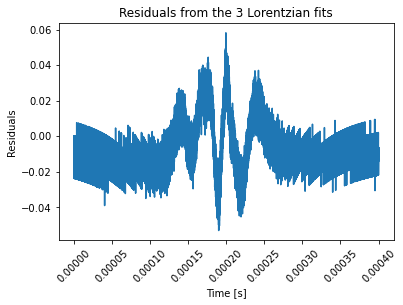

In [49]:
plt.plot(t, residuals_1d)
plt.title('Residuals from the 3 Lorentzian fits')
plt.xlabel('Time [s]')
plt.ylabel('Residuals')
plt.xticks(rotation = 45)

The look of the residuals does not look much random, rather it seems there is still some structure to it, especially near the peak. It is hence fair to say that our model of the three Lorentzian could be upgraded, and that it models our data in a limited fashion given the structure of the residuals. However, our current model is not that bad, with the structure having an amplitude of order ~ 0.04.

f)

In [ ]:
# Need cov_d
p_rand1, p_rand2, p_rand3 = p_calc_1d + cov_d@np.random.randn(len(p_calc_1d)), p_calc_1d + cov_d@np.random.randn(len(p_calc_1d)), p_calc_1d + cov_d@np.random.randn(len(p_calc_1d))


ye1, grad_e1 = calc_lorentzian_sum(p_rand1, t)
ye2, grad_e2 = calc_lorentzian_sum(p_rand2, t)
ye3, grad_e3 = calc_lorentzian_sum(p_rand3, t)


res1 = d - ye1
res2 = d - ye2
res3 = d - ye3

chisq1, chisq2, chisq3 = res1.transpose()@cov_inv_d@res1, res2.transpose()@cov_inv_d@res2, res3.transpose()@cov_inv_d@res3
chisq = residual.transpose()@cov_inv_d@residual

g)

In [24]:
def mcmc(p, t, signal, noise, step_size, num_steps):
    # Calculate initial chi sqaured value
    chisq_i = chisq(p, t, signal, noise)

    # Define the arrays which will hold the Monte-Carlo results and the chi squared values at each step
    chain = np.zeros([num_steps, len(p)])
    chisq_vals = np.zeros(num_steps)

    # loop through the mcmc 
    for i in range(num_steps):
        # Update the p value
        p_new = p + step_size*np.random.randn(len(p))
        chisq_f = chisq(p_new, t, signal, noise)
        if chisq_f < chisq_i:
            accept = True
        else:
            dchisq = chisq_f - chisq_i
            # print("dchisq:", dchisq, "iteration:", i)
            if np.random.rand(1)<np.exp(-0.5*(dchisq)):
                accept = True
            else: 
                accept=False
        if accept:
            p, chisq_i = p_new, chisq_f
        chain[i,:] = p
        chisq_vals[i] = chisq_i

    return chain, chisq_vals

In [25]:
def chisq(p, t, signal, noise):
    y, grad = calc_lorentzian_sum(p, t)
    chisquared = np.sum(((signal - y/noise)**2))
    return chisquared

In [ ]:
step_size_g = np.sqrt(np.diag(cov_d))  # Determine the step size using the covariance matrix from d)
steps = 20000
p_1g = [1.44299239, 0.103910780, 0.0647325300, 0.000192578522, 0.0000445671630, 0.0000160651094] # Best fit params obtained from question 1d
chain, chisq_vals = mcmc(p=p_1g, t=t, signal=d, noise=standard_error, step_size=step_size_g, num_steps=steps)

In [ ]:
a_vals, b_vals, c_vals, t0_vals, t1_vals, omega_vals, i_vals = chain[:,0], chain[:,1], chain[:,2], chain[:,3], chain[:,4], chain[:,5], np.arange(0, steps, 1)
plt.plot(i_vals, b_vals)
plt.show()